# Project: Scientific Claim Checking

Set colab environment and make sure you are using GPUs.

Click Edit and Notebook Settings. Then choose GPU as the hardware accelerator

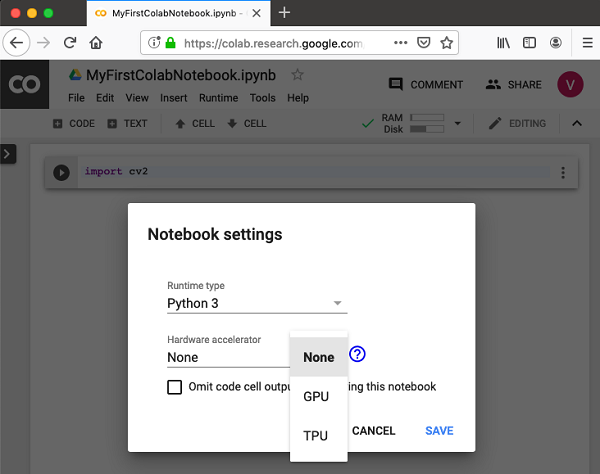

Check if there are GPUs by the command "!nvidia-smi"

In [ ]:
!nvidia-smi

Mon Feb 28 06:48:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download data

Download data from the shared link

In [ ]:
!wget -O /content/train.csv https://www.dropbox.com/s/90z42z12dqd2p2b/train_update.csv?dl=0
!wget -O /content/test_phase_1.csv https://www.dropbox.com/s/9dzmde0ewg2t35l/test_phase_1_update.csv?dl=0

--2022-02-28 05:32:58--  https://www.dropbox.com/s/90z42z12dqd2p2b/train_update.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/90z42z12dqd2p2b/train_update.csv [following]
--2022-02-28 05:32:59--  https://www.dropbox.com/s/raw/90z42z12dqd2p2b/train_update.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8c3abe0c2411a73942739165d6.dl.dropboxusercontent.com/cd/0/inline/BgjenB3m09IY7ThcgDp6rxOxAil1ZTpsgq10KOKC0F9av8sb4wvOdyvgat4wzoPpPVNacZGmIVbhsoZVmbAsZnUvD7nMJwAHcot8_ajjQSfDGTbAZdMlXsMt7wOJWTTuTAvM9ff2mwr0trW5e_XqO0wO/file# [following]
--2022-02-28 05:32:59--  https://uc8c3abe0c2411a73942739165d6.dl.dropboxusercontent.com/cd/0/inline/BgjenB3m09IY7ThcgDp6rxOxAil1ZTpsgq10KOKC0F9av8sb4wvOdyvgat4wzoPpPVNacZ

Check if the datasets have been downloaded sucessfully.

In [ ]:
!ls -lct

total 6024
-rw-r--r-- 1 root root   44891 Feb 28 05:33 test_phase_1.csv
-rw-r--r-- 1 root root  346421 Feb 28 05:33 train.csv
-rw-r--r-- 1 root root 5769039 Feb 28 05:30 nli-model.pt
drwxr-xr-x 1 root root    4096 Feb 24 15:44 sample_data


### Prepare Data

Read data by pandas 

In [ ]:
import pandas as pd

train_df = pd.read_csv('./train.csv') # 1179
test_df = pd.read_csv('./test_phase_1.csv') # 150

Show some data examples in the training and test sets.

In [ ]:
train_df.head(5)

,ID,Claim,Evidence,Label
0,0,Antidepressants increase the severity of migra...,Tricyclics were also more likely to reduce the...,2
1,1,Citrullinated proteins externalized in neutrop...,These observations implicate accelerated NETos...,1
2,2,Recognition of start codons depends on the tra...,IF3 and tRNA undergo large conformational chan...,1
3,3,Ca2+ cycling is a UCP1-dependent thermogenic m...,"Conversely, enhanced Ca2+ cycling by activatio...",2
4,4,Weighed food records (WFR) result in poor comp...,The Hippo pathway controls organ size and tiss...,0


In [ ]:
test_df.head(5)

,ID,Claim,Evidence
0,0,Beta-band coherence is diminished for visible ...,This result suggests that traces of a heavy me...
1,1,Physical activity level is associated with the...,The best diagnostic performance is obtained wh...
2,2,Autologous transplantation of mesenchymal stem...,"After 6 months, 4 of 53 patients (7.5%) in the..."
3,3,RAD52 is involved in break-induced DNA replica...,"At CFSs, this fragility is associated with a d..."
4,4,Human embryonic stem cells give rise to cell t...,Embryonic stem cells have the ability to remai...


Install transformers and pytorch_lightning to prepare for T5

In [9]:
!pip install transformers==2.9.0
!pip install pytorch_lightning==0.7.5
!pip install sentencepiece

     |████████████████████████████████| 635 kB 4.4 MB/s 
     |████████████████████████████████| 5.6 MB 26.7 MB/s 
     |████████████████████████████████| 895 kB 33.8 MB/s 
     |████████████████████████████████| 1.2 MB 37.6 MB/s 
     |████████████████████████████████| 233 kB 4.3 MB/s 
     |████████████████████████████████| 829 kB 38.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=06dcdf5cc88f8e2530c7670fea79dcb808eaa706ab9c6b52be485ed178873135
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


# How we can improve this model
- 1. (Please try this first) We can set the max_len of the model to 512, due to the lack of GPU, I can only use TPU in colab and their server don't support a standard max_len=512 and this could means that we can't make fully use of the pretrained T5 model. and also if you have enough resources please try T5-large which will have a better performance.
- 2. We can split the task into "NonInfo and Info" and "Support and Refutes", since t5 have many different mechanism to avoid overfitting, this should be quite straightforward and effective, meanwhile, I have also check the validation set examples, most cases are misclassified between Support and Refutes.
- 3. Try to design a metric to monitor performance but since T5 model can only be used in a text2text task, I am not sure this will help

# T5 fine-tuning
This notebook is to showcase how to fine-tune T5 model with Huggigface's Transformers to solve different NLP tasks using text-2-text approach proposed in the T5 paper. 

In [10]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
from transformers import AdamW,T5ForConditionalGeneration,T5Tokenizer,get_linear_schedule_with_warmup


INFO:transformers.file_utils:PyTorch version 1.10.0+cu111 available.
INFO:transformers.file_utils:TensorFlow version 2.8.0 available.


In [12]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Model
We'll be using the awesome pytorch-lightning library for training. Most of the below code is adapted from here https://github.com/huggingface/transformers/blob/master/examples/lightning_base.py

The trainer is generic and can be used for any text-2-text task. You'll just need to change the dataset. Rest of the code will stay unchanged for all the tasks.

This is the most intresting and powrfull thing about the text-2-text format. You can fine-tune the model on variety of NLP tasks by just formulating the problem in text-2-text setting. 

In [13]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [14]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [15]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=256,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

# Split train and valid 

In [16]:
train_examples = []
for index, row in train_df.iterrows():
  # print (row)
  claim, evidence, label = row['Claim'], row['Evidence'], row['Label']
  train_examples.append([claim.strip(), evidence.strip(), label])

random.shuffle(train_examples)
valid_num = int(len(train_examples)*0.1)
valid_examples = train_examples[:valid_num]
train_examples = train_examples[valid_num:]

test_examples = []
for index, row in test_df.iterrows():
  # print (row)
  claim, evidence = row['Claim'], row['Evidence']
  test_examples.append([claim.strip(), evidence.strip()])

In [17]:
train_examples[0]

['Risk-adjusted mortality rates are similar in teaching and non-teaching hospitals.',
 "Conclusions  The available data are limited by their nonrandomized design, but overall they do not suggest that a healthcare facility's teaching status on its own markedly improves or worsens patient outcomes.",
 1]

In [18]:
label_int = {"NonInfo":0,"Supports":1, 'Refutes':2}
labels = ['NonInfo',"Supports","Refutes"]

In [19]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
for label in labels:
  print(len(tokenizer.encode(label)))

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpd7c8a4z1


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


2
2
4


# How we form the task
This is how we form the task, In input we form the format of 
- **"Claim:"+ simple[0] + "Evidence:" + simple[1]**

and in output we directly use the labels 
- **"NonInfo" "Supports" and "Refutes"** 


Due to the fact that T5 can only be used in a text2text task which means that input and output both have to be a 
sentence and the output won't always be within the labels such as the output could be "NotInfo", it's hard to directly use a metric to monitor model performance.

In [61]:
class FactDataset(Dataset):
  def __init__(self, tokenizer,data,  max_len=256):
    
    self.data = data
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for simple in self.data:
      if len(simple) == 3:
        input_, target = "Claim:"+ simple[0] + "Evidence:" + simple[1], labels[simple[2]]    
      else:
        input_, target = "Claim:"+ simple[0] + "Evidence:" + simple[1], labels[0]    

      input_ = input_ + ' </s>'
      target = target + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [21]:
train_dataset =FactDataset(tokenizer,train_examples, 256)
print(len(train_dataset))
valid_dataset = FactDataset(tokenizer,valid_examples, 256)
print(len(valid_dataset))

1062
117


In [22]:
data = train_dataset[5]
print(tokenizer.decode(data['target_ids']))

NonInfo


In [23]:
data = train_dataset[40]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

Claim:Patients in stable partnerships progress from HIV to death at the same rate as patients not in partnerships.Evidence:In an analysis stratified by previous antiretroviral therapy and clinical stage when starting HAART (US Centers for Disease Control and Prevention group A, B, or C), the adjusted hazard ratio for progression to AIDS or death was 0.79 (95% confidence interval 0.63 to 0.98) for participants with a stable partnership compared with those without.
Ref


In [41]:
args_dict.update({'data_dir': 'fact_data', 'output_dir': 't5_fact', 'num_train_epochs':20})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'fact_data', 'output_dir': 't5_fact', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 256, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 20, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [25]:
!mkdir -p t5_fact

In [42]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory t5_fact exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


Print the predictions of the test data examples

In [43]:
def get_dataset(tokenizer, type_path, args):
  if type_path == 'train':
    return FactDataset(tokenizer,train_examples, max_len=args.max_seq_length)
  elif type_path =='val':
    return FactDataset(tokenizer,valid_examples, max_len=args.max_seq_length)

In [44]:
model = T5FineTuner(args)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
   

In [45]:
trainer = pl.Trainer(**train_params)
trainer.fit(model)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList          

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.6513, device='cuda:0')

INFO:__main__:loss = tensor(0.6924, device='cuda:0')

INFO:__main__:train_loss = tensor(0.6924, device='cuda:0')

INFO:__main__:val_loss = tensor(0.6513, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(4.2864, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.6170, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.6228, device='cuda:0')

INFO:__main__:train_loss = tensor(0.6228, device='cuda:0')

INFO:__main__:val_loss = tensor(0.6170, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.6199, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.3568, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(0.2888, device='cuda:0')

INFO:__main__:train_loss = tensor(0.2888, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3568, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.4456, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.2729, device='cuda:0')

INFO:__main__:epoch = 2

INFO:__main__:loss = tensor(0.0615, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0615, device='cuda:0')

INFO:__main__:val_loss = tensor(0.2729, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.2897, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.2474, device='cuda:0')

INFO:__main__:epoch = 3

INFO:__main__:loss = tensor(0.1124, device='cuda:0')

INFO:__main__:train_loss = tensor(0.1124, device='cuda:0')

INFO:__main__:val_loss = tensor(0.2474, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.1860, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.3099, device='cuda:0')

INFO:__main__:epoch = 4

INFO:__main__:loss = tensor(0.1687, device='cuda:0')

INFO:__main__:train_loss = tensor(0.1687, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3099, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.1117, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.3074, device='cuda:0')

INFO:__main__:epoch = 5

INFO:__main__:loss = tensor(0.0025, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0025, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3074, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0835, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.3385, device='cuda:0')

INFO:__main__:epoch = 6

INFO:__main__:loss = tensor(0.0111, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0111, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3385, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0437, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4093, device='cuda:0')

INFO:__main__:epoch = 7

INFO:__main__:loss = tensor(0.0004, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0004, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4093, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0231, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4773, device='cuda:0')

INFO:__main__:epoch = 8

INFO:__main__:loss = tensor(0.0064, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0064, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4773, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0227, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4379, device='cuda:0')

INFO:__main__:epoch = 9

INFO:__main__:loss = tensor(0.0015, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0015, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4379, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0194, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4727, device='cuda:0')

INFO:__main__:epoch = 10

INFO:__main__:loss = tensor(0.0007, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0007, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4727, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0130, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4698, device='cuda:0')

INFO:__main__:epoch = 11

INFO:__main__:loss = tensor(0.0014, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0014, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4698, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0137, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4872, device='cuda:0')

INFO:__main__:epoch = 12

INFO:__main__:loss = tensor(0.0049, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0049, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4872, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0119, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.5220, device='cuda:0')

INFO:__main__:epoch = 13

INFO:__main__:loss = tensor(0.0023, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0023, device='cuda:0')

INFO:__main__:val_loss = tensor(0.5220, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0034, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4899, device='cuda:0')

INFO:__main__:epoch = 14

INFO:__main__:loss = tensor(0.0001, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0001, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4899, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0060, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4867, device='cuda:0')

INFO:__main__:epoch = 15

INFO:__main__:loss = tensor(0.0459, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0459, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4867, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0033, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4869, device='cuda:0')

INFO:__main__:epoch = 16

INFO:__main__:loss = tensor(0.0024, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0024, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4869, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0063, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4854, device='cuda:0')

INFO:__main__:epoch = 17

INFO:__main__:loss = tensor(0.1108, device='cuda:0')

INFO:__main__:train_loss = tensor(0.1108, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4854, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0059, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4858, device='cuda:0')

INFO:__main__:epoch = 18

INFO:__main__:loss = tensor(0.0004, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0004, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4858, device='cuda:0')



1

In [31]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [46]:
dataset = FactDataset(tokenizer, valid_examples, 256)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  # print(len(dec))
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  # print(len(target))
  outputs.extend(dec)
  targets.extend(target)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/4 [00:00<?, ?it/s]

In [56]:
print(len(targets))

117


In [54]:
print(outputs)

['Re', 'Non', 'Support', 'Non', 'Support', 'Re', 'Non', 'Support', 'Re', 'Re', 'Support', 'Support', 'Re', 'Support', 'Re', 'Non', 'Re', 'Non', 'Re', 'Support', 'Support', 'Support', 'Non', 'Re', 'Re', 'Support', 'Support', 'Support', 'Non', 'Re', 'Support', 'Support', 'Support', 'Support', 'Support', 'Support', 'Re', 'Support', 'Non', 'Re', 'Support', 'Support', 'Non', 'Non', 'Support', 'Support', 'Support', 'Support', 'Support', 'Support', 'Non', 'Support', 'Non', 'Non', 'Support', 'Support', 'Support', 'Non', 'Re', 'Non', 'Non', 'Re', 'Re', 'Support', 'Support', 'Re', 'Re', 'Non', 'Re', 'Support', 'Non', 'Non', 'Re', 'Support', 'Re', 'Re', 'Support', 'Support', 'Support', 'Support', 'Re', 'Re', 'Re', 'Re', 'Re', 'Re', 'Non', 'Support', 'Re', 'Support', 'Support', 'Non', 'Non', 'Re', 'Non', 'Support', 'Support', 'Support', 'Re', 'Support', 'Re', 'Re', 'Non', 'Re', 'Non', 'Non', 'Support', 'Re', 'Support', 'Support', 'Support', 'Non', 'Support', 'Non', 'Re', 'Non', 'Support']


In [57]:
results= []
for i in outputs:
  if i == "Re":
    results.append(2)
  elif i == "Non":
    results.append(0)
  elif i == "Support":
    results.append(1)
  else:
    print("error")

In [58]:
valid = []
for i in targets:
  if i == "Ref":
    valid.append(2)
  elif i == "NonInfo":
    valid.append(0)
  elif i == "Supports":
    valid.append(1)
  else:
    print("error")

In [59]:
metrics.accuracy_score(valid, results)


0.8290598290598291

In [62]:
dataset = FactDataset(tokenizer, test_examples, 256)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []

for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  # print(len(dec))
  
  # print(len(target))
  outputs.extend(dec)
  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/5 [00:00<?, ?it/s]

In [63]:
results= []
for i in outputs:
  if i == "Re":
    results.append(2)
  elif i == "Non":
    results.append(0)
  elif i == "Support":
    results.append(1)
  else:
    print("error")

In [65]:
len(results)

150

In [70]:
results

[0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 2,
 1,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 0,
 1]

### Prepare Submission Files

- Copy the above results and paste them into a submission file in your own pc desktop, like "sub.txt"
- Compress the file as a zip file, like "sub.txt.zip"
- submit your file to the competition website. 
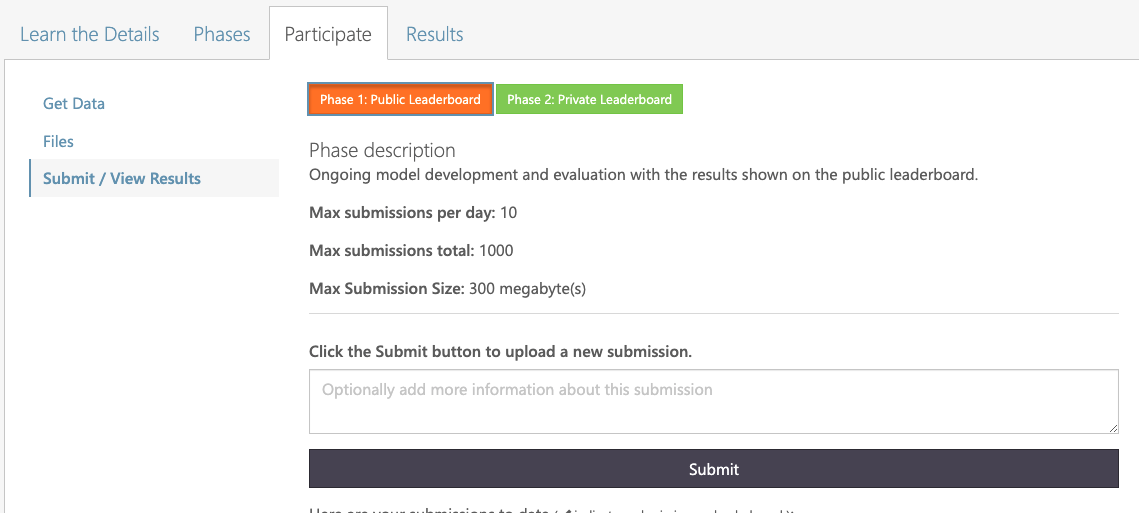

This simple baseline based on LSTM will help you get around 0.54 scores. Please try more models and strategies to beat a stronger baseline with 0.73 scores.

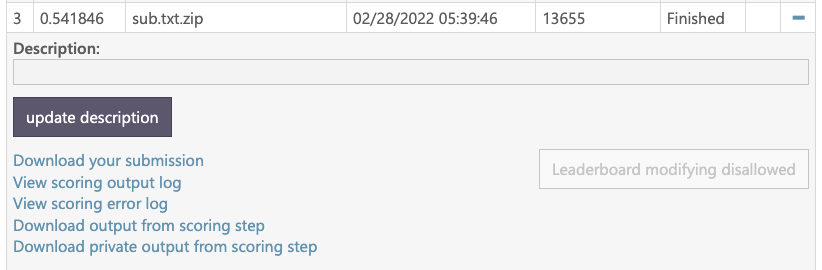